# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a phto of a dog, I want to know breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We're dealing with the image (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels)
*There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


### Get out workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [2]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Check for GPU availability
print('GPU', 'available (YESSSSS!!!!!)' if tf.config.list_physical_devices('GPU') else 'not avaliable :(')

TF version: 2.4.0
TF Hub version: 0.11.0
GPU available (YESSSSS!!!!!)


## Getting our data ready (turning it into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels ouf our data
import pandas as pd
labels_csv = pd.read_csv('/content/drive/MyDrive/Dog Vision/dog-breed-identification/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     79830abe3ee01ebd66d13324aa69ddd2  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


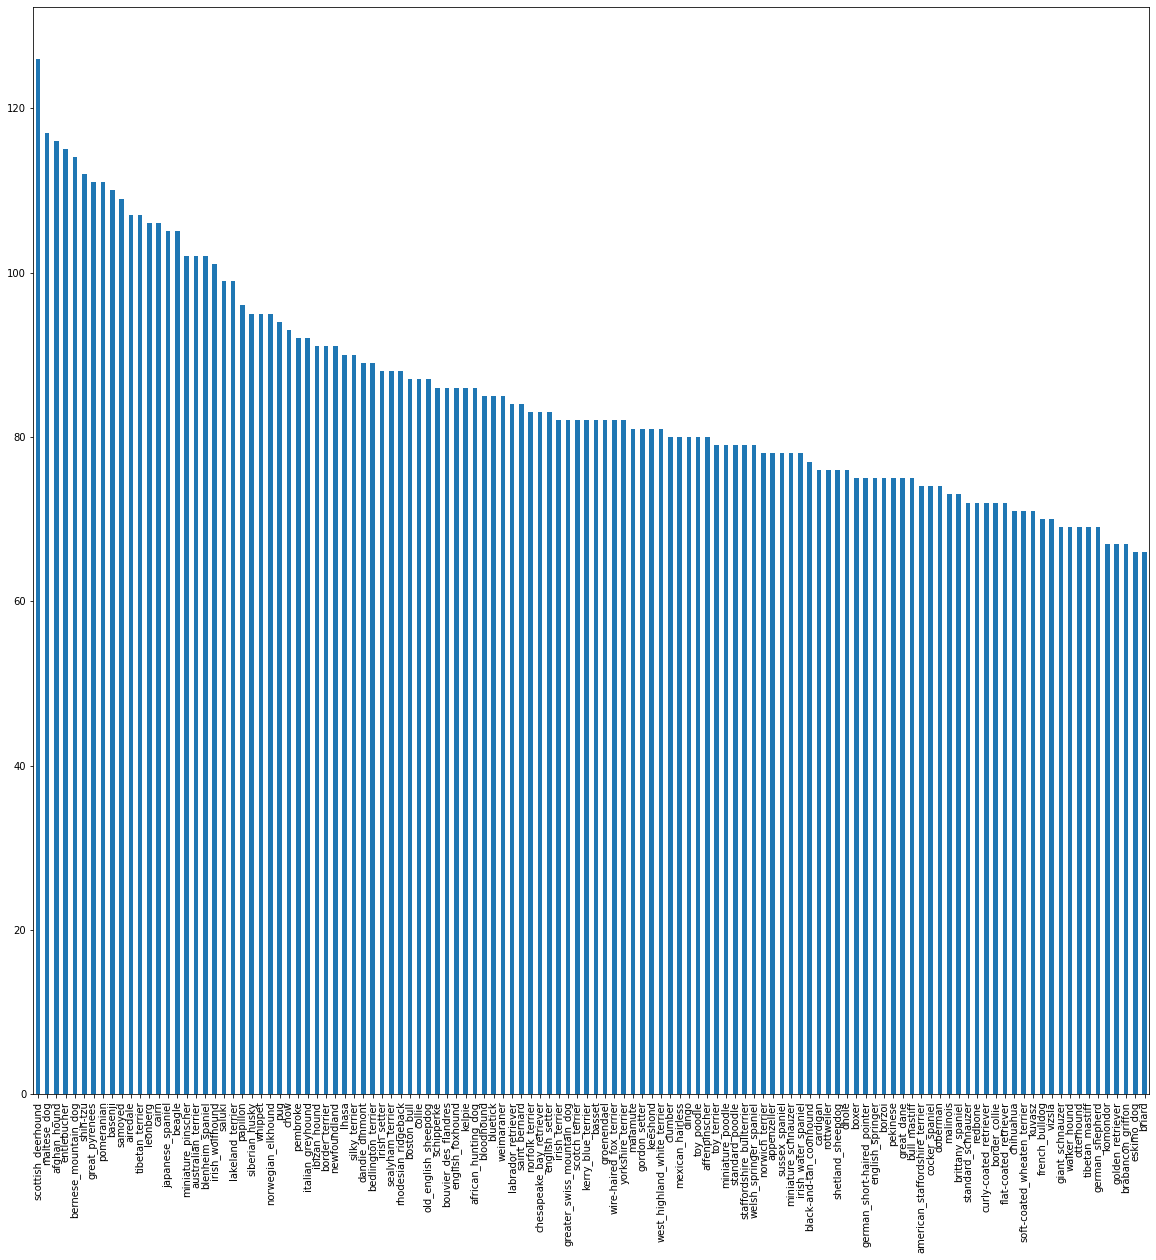

In [5]:
# How many images are there of each breed

labels_csv.breed.value_counts().plot.bar(figsize=(20, 20))

In [6]:
labels_csv.breed.value_counts().median()

82.0

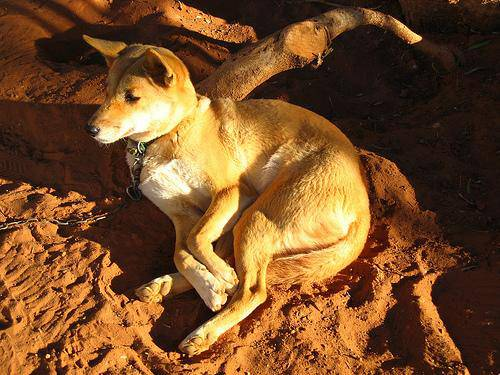

In [7]:
# Let's view an image
from IPython.display import Image

Image('/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and thier labels

Let's get a list of all out image file pathnames.

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# Create pathnames from image ID's
filenames = ['drive/MyDrive/Dog Vision/dog-breed-identification/train/'+fname+'.jpg' for fname in labels_csv.id]

# Check the first ten filenames
filenames[:10]

['drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
import os
os.listdir('/content/drive/MyDrive/Dog Vision/dog-breed-identification/train')[:10]

['e7ab11f849e895ced3cdddf4d90e5bd2.jpg',
 'e7bc17ef352ef576b73467ebe9a407f1.jpg',
 'e79cc376c53b8333546437ca6e5b8759.jpg',
 'e8013a8357f9eec2369ee4e3fab710a1.jpg',
 'e79a196a6e1772b9fa6b008b597d3a08.jpg',
 'e7af30693df78697b8541fb5e2e46941.jpg',
 'e7f4f3c25291884f2dfe7c60051d6949.jpg',
 'e79578de293a0b46e92448ce8f8bb69f.jpg',
 'e79f822b26adace4455db1fcd94ab47e.jpg',
 'e818d5a7782350e72171c3dfa05af02a.jpg']

In [11]:
# Check whether number of filenames mathces number of actual image files
import os
if len(os.listdir('/content/drive/MyDrive/Dog Vision/dog-breed-identification/train')) == len(filenames):
    print('Filenames match actual amount of files!!! Proceed.')
else:
    print('Filenames do not match actual amount of files, check the target directory.')

Filenames match actual amount of files!!! Proceed.


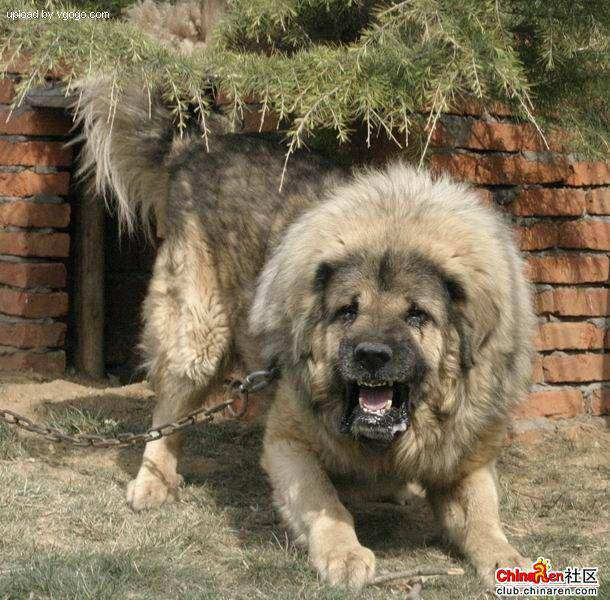

In [12]:
# One more check
Image(filenames[9000])

In [13]:
labels_csv.iloc[9000]['breed']

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels

In [14]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
#labels = np.array(labels) # does same thing as above

labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels mathces the number of filenames

if len(labels) == len(filenames):
    print('Number of labels matches number of filenames!')
else:
    print('Number of labels does not match number of filenames, check data directories')

Number of labels matches number of filenames!


In [17]:
# Find the unique label values

unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
# turn a singlel labels into an array of booleans

print(labels[0])

labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
len(labels)

10222

In [20]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [22]:
# Example: Turning boolean array into integers
print(labels[0]) # original labels
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
print(labels[1])
print(boolean_labels[1].astype(int))

dingo
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from kaggle doesn't come with a validation set, we're going to create our own.

In [24]:
# Setup X and y variables

X = filenames
y = boolean_labels

In [25]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and icrease as needed.

In [26]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [27]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUm_IMAGEs
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [28]:
print(X_train[:2])
print(y_train[:2])

['drive/MyDrive/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg', 'drive/MyDrive/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg']
[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, F

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're goint to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
5.  Return the modified image `image`

In [29]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [30]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [31]:
# Turn image into a tensor
tf.constant(image)[0]

<tf.Tensor: shape=(350, 3), dtype=uint8, numpy=
array([[ 89, 137,  87],
       [ 76, 124,  74],
       [ 63, 111,  59],
       ...,
       [ 76, 134,  86],
       [ 76, 134,  86],
       [ 76, 134,  86]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Resize the image to be a shape of (224, 224)
5. Return the modified image image

In [32]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images

def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)

    # Turn the jpeg image into numeric Tensor with 3 colout channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the colout channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)

    #Resize the image to out specified (224, 224)
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,00+ images in one go... they all might nt fit into memory.

So that's why we do about 32 images (this is the batch size) at at time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [33]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and returns a tuple of (image, label).
    """
    
    image = process_image(image_path)
    return image, label

In [34]:
# demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors (in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [35]:
# Define the bacth size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into bacthes
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates bacthes of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """

    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels

        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print('Creating training data batches...')
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames and labelsa before mapping image processor function is faster than shuffling
        data = data.shuffle(buffer_size=len(X))
        
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        
        return data_batch

In [36]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [37]:
# Check out the different attributes of our data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [38]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data bacth

def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """

    # Setup a figure
    plt.figure(figsize=(10, 10))

    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)

        # Display an image
        plt.imshow(images[i])

        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])

        # turn the grid lines off
        plt.axis('off')

In [39]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [40]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [41]:
len(train_images), len(train_labels)

(32, 32)

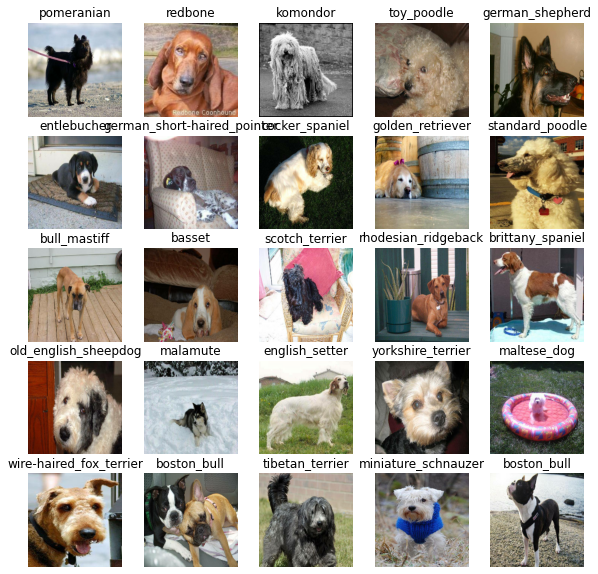

In [42]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

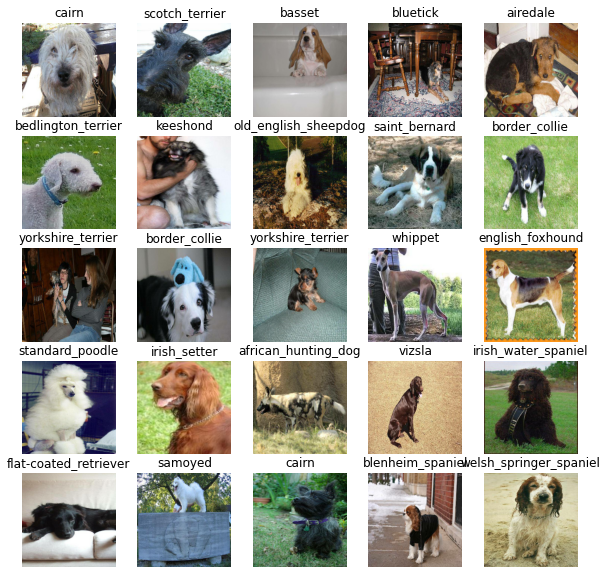

In [43]:
# Now let's visualize our validations et
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few thing we need to define:
* The input shape (out images shape, in the form of Tensors) to our model.
* The output shape (image, labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub.

In [44]:
IMG_SIZE

224

In [45]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Select output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model Url from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

In [46]:
MODEL_URL

'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: 
https://www.tensorflow.org/guide/keras/sequential_model

In [47]:
# Create a function which builds a Keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):

    """
    Creates a keras sequential model from a model already on tensor hub (mobilenet_v2_130_224/classification/4)
    """

    print('Building model with:', MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                              activation='softmax') # Layer 2 (output shape)
    ])

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Build the model
    model.build(INPUT_SHAPE)
    
    return model

In [48]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functtions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

we'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [49]:
# load TensorBoard notebook extension
%load_ext tensorboard

In [50]:
import datetime

# Create a function to build a TensorBoard callback

def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join('drive/MyDrive/Dog Vision/logs', 
                          # Make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evalutation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [51]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a model (on subset of data)

Our fitst model is only going to train on 1000 images, to make sure everything is working.

In [52]:
NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100, step:10}

In [53]:
# check to make sure we're still running on a GPU
print('GPU', 'available (YESSS!!!!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

GPU available (YESSS!!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epoches to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [54]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """

    # Create a model
    model = create_model()

    # Create a TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=val_data,
              callbacks=[tensorboard, early_stopping])
    
    # Return the fitted model
    return model

In [55]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 255s 10s/step - loss: 4.9510 - accuracy: 0.0611 - val_loss: 3.4186 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 4s 169ms/step - loss: 1.8866 - accuracy: 0.6084 - val_loss: 2.2419 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 4s 172ms/step - loss: 0.6719 - accuracy: 0.9035 - val_loss: 1.7771 - val_accuracy: 0.5450
Epoch 4/100
25/25 [==============================] - 4s 170ms/step - loss: 0.2659 - accuracy: 0.9873 - val_loss: 1.5987 - val_accuracy: 0.5800
Epoch 5/100
25/25 [==============================] - 4s 172ms/step - loss: 0.1521 - accuracy: 0.9973 - val_loss: 1.5177 - val_accuracy: 0.5850
Epoch 6/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0979 - accuracy: 0.9998 - val_loss: 1.4659 - val_accuracy: 0.6150
Epoch 7/100
25/25 [==============================

**Question:** It looks like the model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some way to prevent model overfitting in deep learning neural networks.

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs

The TensorBoard magic function (`tensorboard`) will access the logs directory we crated earlier and visualize its content.

In [56]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [57]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [58]:
# Make predictions on the validation data. (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 122ms/step


array([[6.7913844e-03, 1.4325972e-04, 1.3066514e-03, ..., 3.8274250e-04,
        2.5326641e-05, 1.4120489e-03],
       [2.4266033e-03, 1.2420098e-03, 2.8896522e-02, ..., 2.6725635e-03,
        6.1961380e-03, 2.8357640e-04],
       [6.0573977e-05, 1.2015629e-03, 7.2019116e-05, ..., 9.2598537e-05,
        8.8722074e-05, 8.6540218e-05],
       ...,
       [8.7070002e-05, 1.8036817e-04, 3.3916172e-04, ..., 8.2014114e-05,
        1.8837655e-04, 9.8368095e-04],
       [1.3024267e-03, 1.1620059e-03, 8.1146158e-05, ..., 1.5649597e-04,
        1.7685765e-04, 1.7754983e-02],
       [9.9908779e-05, 4.7641566e-05, 3.7884009e-03, ..., 7.2874911e-03,
        7.0624505e-03, 1.8989283e-04]], dtype=float32)

In [59]:
np.sum(predictions[0])

0.99999994

In [60]:
predictions.shape

(200, 120)

In [61]:
len(y_val)

200

In [62]:
len(unique_breeds)

120

In [63]:
# First prediction

index = 1
print(predictions[index])
print(f'Max value (probablity of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

[2.42660334e-03 1.24200981e-03 2.88965218e-02 4.61629871e-03
 6.22607768e-04 2.48716970e-04 9.32220276e-03 1.93721033e-04
 3.87149164e-04 4.71995154e-04 8.63107853e-04 1.95832836e-04
 6.10940799e-04 4.80894641e-06 9.23895161e-04 1.46905164e-04
 6.74904464e-03 2.36298144e-03 1.20198689e-04 3.50017857e-04
 9.99147072e-04 7.25230639e-05 1.41955097e-04 3.21250496e-04
 9.22265244e-05 3.50113871e-04 1.74894072e-02 5.02145942e-03
 1.16187439e-04 1.35278085e-03 1.65309146e-04 8.24113158e-05
 2.94840196e-03 4.20310971e-05 1.60016134e-04 4.77335299e-04
 7.40566058e-04 4.35159588e-03 1.46431892e-04 1.20328172e-04
 2.62000540e-04 1.17806288e-04 3.70833790e-04 5.30923193e-04
 2.01566657e-03 1.96398119e-03 1.18093914e-04 2.90092139e-04
 3.83639932e-02 1.11301870e-05 2.33511411e-04 5.96232887e-04
 1.28506334e-04 1.56533337e-04 2.36607739e-03 8.77820794e-03
 6.64126856e-05 1.86179802e-02 1.01226804e-04 3.54419299e-03
 4.01844911e-04 3.00599163e-06 2.24677773e-04 1.36400733e-04
 1.14382710e-02 8.415431

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being mage on!

**Note:** Prediction probabilities are also known as confidence levels.

In [64]:
# Turn prediction probabilites into thier respective label (easier to understand)

def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """

    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label bases on n array of prediction porbabilites
pred_label = get_pred_label(predictions[0])
pred_label

'border_terrier'

Now sine our validation is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).


In [65]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [66]:
# Create a function to unbatch a dataset

def unbatchify(data):
    """
    Unbatchifies data and returns images and labels
    """

    images_ = []
    labels_ = []

    # Loop thorugh unbacthed data
    for image, label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])

    return images_, labels_

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [67]:
get_pred_label(val_labels[0])

'affenpinscher'

Now we've got ways to get:
* Predictions labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visual.

We'll create a function which:
* Takes an array of prediction probabilites, ann array of truth labels and an array of images and an integer.
* Conver the prediction probabilites to a predicted label.
* Plot the predicted label, its predicted probablity, the truth label and the target image on a single plot.

In [68]:
def plot_pred(prediction_probs, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """

    pred_prob, true_label, image = prediction_probs[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    plt.axis('off')

    # Change the colour of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    # Change plot title to be predicted, probabliry of prediction and truth label
    plt.title("Predicted Breed: {}\nConfidence of Prediction: {:2.0f}%\n True Breed: {}".format(pred_label,
                                       np.max(pred_prob)*100,
                                       true_label),
                                       color=color)

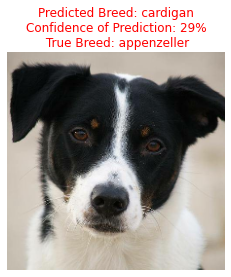

In [69]:
plot_pred(prediction_probs=predictions, labels=val_labels, images=val_images, n=199)

Now we've got one function to visualize our models top predictions, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilites array and a ground truth array and an integer
* find the prediction using `get_pred_label()`
* Find the top 10:
    * Prediction probabilities indexes
    * Prediction probabilities values
    * Prediction labels
* Plot the top 10 prediction probabilirt values and labels, coloring the true label green

In [70]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plot the top 10 highest prediction confidences along with the truth label for sample n.
    """

    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label  = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    # Find the top 10 predicion confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color='grey')
    
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation='vertical')
    
    # Change colour of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass

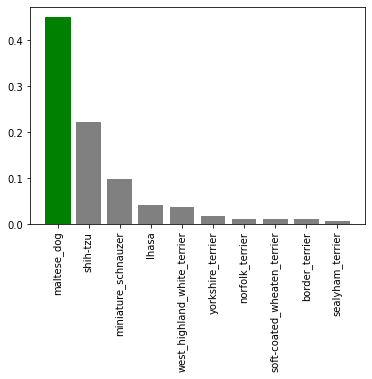

In [71]:

plot_pred_conf(prediction_probabilities=predictions,
              labels=val_labels,
              n=198)

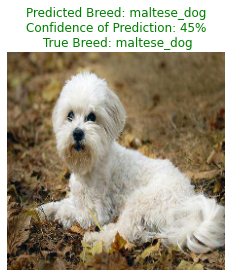

In [72]:
plot_pred(prediction_probs=predictions, labels=val_labels, images=val_images, n=198)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

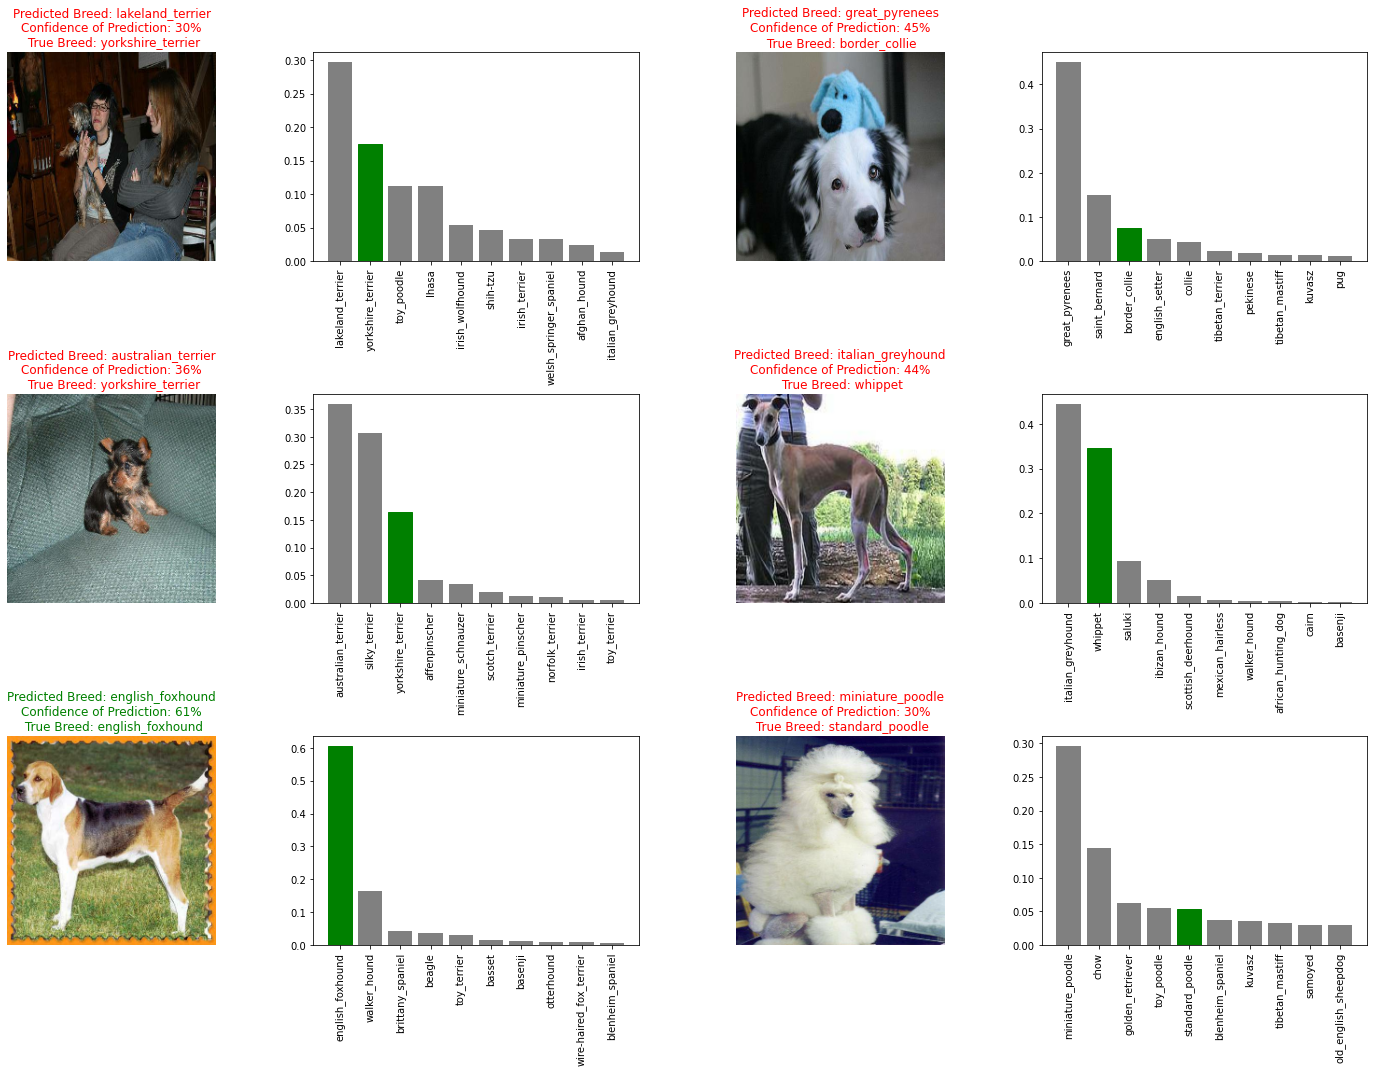

In [73]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probs=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)   
plt.show()




**Challenge**: How would you create a confusion matrix with our models predictions and true labels?

In [74]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=40)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


Confusion matrix, without normalization
[[2 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]]


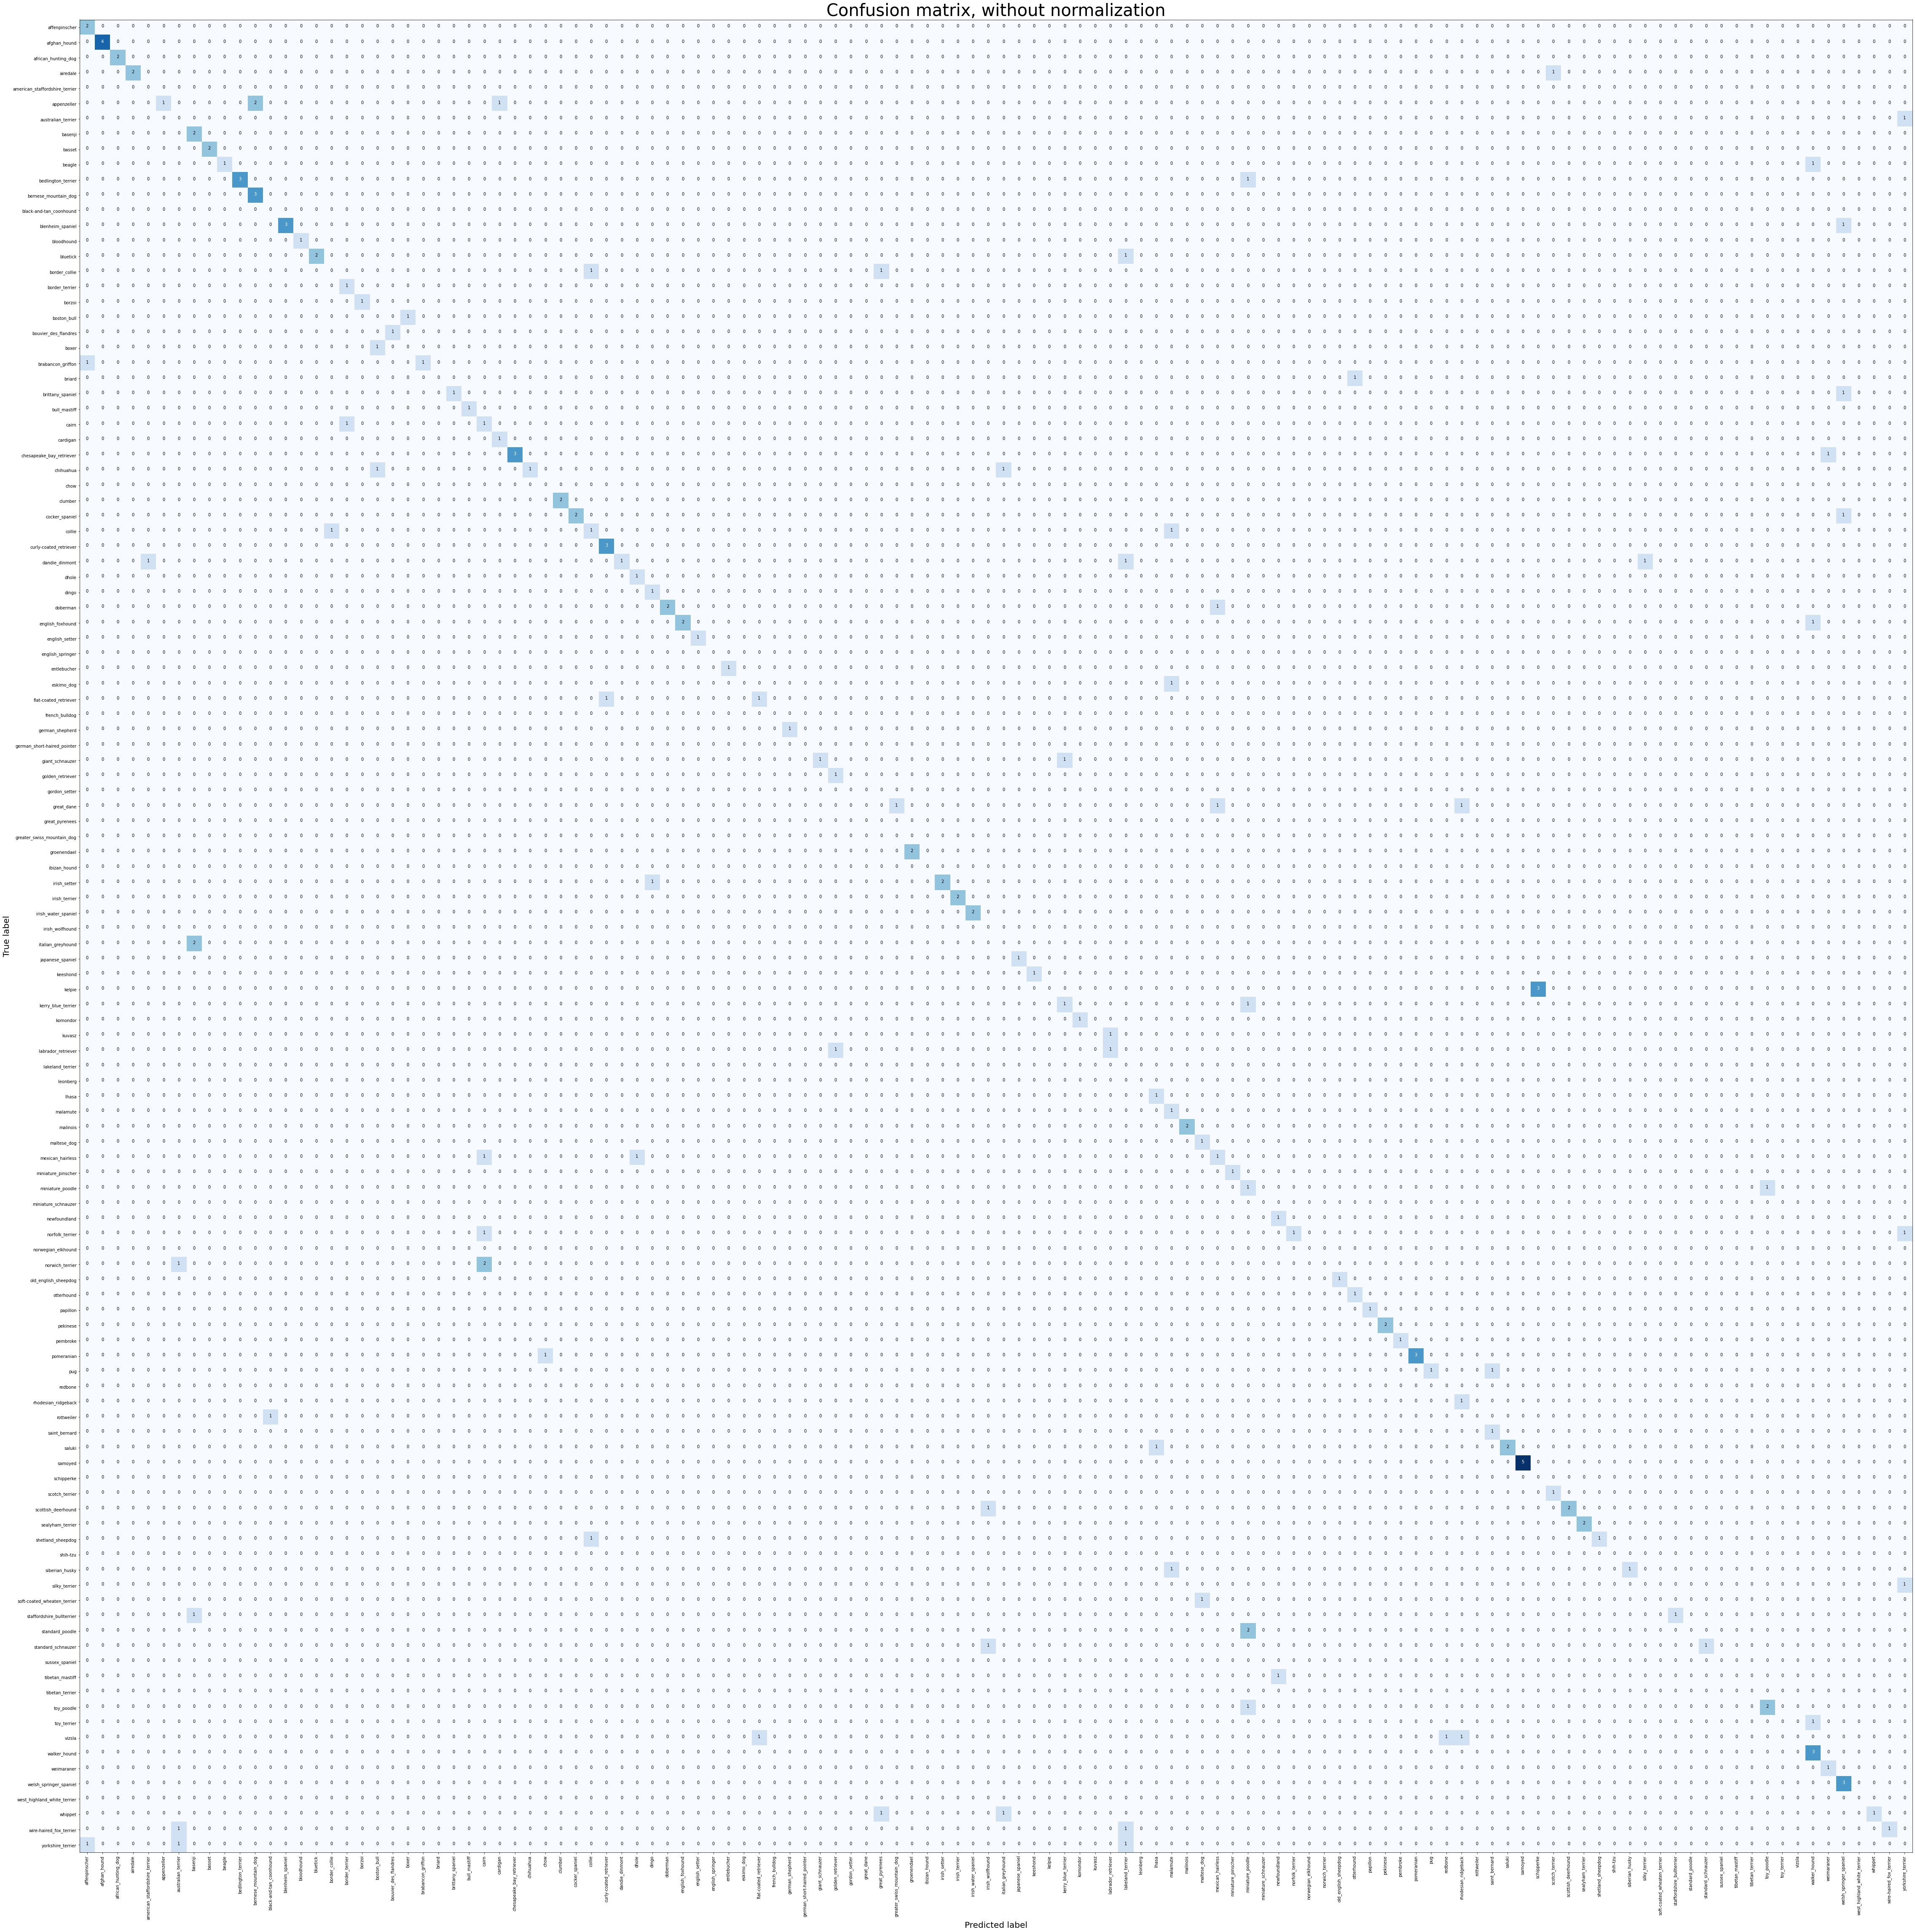

In [75]:
y_pred = []
for pred in predictions:
    y_pred.append(get_pred_label(pred))

cnf_matrix = confusion_matrix(val_labels, y_pred, labels=unique_breeds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(80,80))
plot_confusion_matrix(cnf_matrix, classes=unique_breeds,
                      title='Confusion matrix, without normalization')

## Saving and reloading a trained model

In [76]:
# Create a function ro save a model

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appens a suffix (string)
    """

    # Create a model directory pathname with current time
    modeldir = os.path.join('drive/MyDrive/Dog Vision/models',
                            datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
    
    model_path = modeldir +'_' + suffix + '.h5' # save format to a model
    print(f'Saving model to {model_path}...')
    model.save(model_path)

    return model_path

In [77]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """

    print(f'Loading saved model from: {model_path}')

    model = tf.keras.models.load_model(model_path,
                                        custom_objects={'KerasLayer':hub.KerasLayer})
    
    return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [78]:
# save our model trained on 1000 images
save_model(model, suffix='1000-images-mobilenetv2-Adam')

Saving model to drive/MyDrive/Dog Vision/models/20210124-22481611528485_1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20210124-22481611528485_1000-images-mobilenetv2-Adam.h5'

In [79]:
# Load a trained model
loaded_1000_image_model = load_model('drive/MyDrive/Dog Vision/models/20210123-04041611374656_1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog Vision/models/20210123-04041611374656_1000-images-mobilenetv2-Adam.h5


In [80]:
# Evaluate the pre-saved model

model.evaluate(val_data)

7/7 [==============================] - 1s 103ms/step - loss: 1.3843 - accuracy: 0.6150


[1.3842883110046387, 0.6150000095367432]

In [81]:
# Evaluate the loaded model

loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 2s 112ms/step - loss: 1.2511 - accuracy: 0.6950


[1.2510854005813599, 0.6949999928474426]

## Training a big dog model (on the full data)

In [82]:
len(X), len(y)

(10222, 10222)

In [83]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [84]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [85]:
# Create full model callbacks

full_model_tensor_board = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                               patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [86]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensor_board, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 2552s 8s/step - loss: 2.3711 - accuracy: 0.4839
Epoch 2/100
320/320 [==============================] - 40s 124ms/step - loss: 0.3837 - accuracy: 0.8910
Epoch 3/100
320/320 [==============================] - 40s 124ms/step - loss: 0.2295 - accuracy: 0.9369
Epoch 4/100
320/320 [==============================] - 39s 123ms/step - loss: 0.1472 - accuracy: 0.9692
Epoch 5/100
320/320 [==============================] - 40s 123ms/step - loss: 0.1000 - accuracy: 0.9810
Epoch 6/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0689 - accuracy: 0.9907
Epoch 7/100
320/320 [==============================] - 40s 124ms/step - loss: 0.0534 - accuracy: 0.9932
Epoch 8/100
320/320 [==============================] - 40s 124ms/step - loss: 0.0421 - accuracy: 0.9964
Epoch 9/100
320/320 [==============================] - 39s 123ms/step - loss: 0.0345 - accuracy: 0.9973
Epoch 10/100
320/320 [==============================] - 39s 123ms

In [87]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

Saving model to drive/MyDrive/Dog Vision/models/20210124-23401611531637_full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20210124-23401611531637_full-image-set-mobilenetv2-Adam.h5'

In [88]:
# Load in the full model
loaded_full_model = load_model('drive/MyDrive/Dog Vision/models/20210123-05141611378874_full-image-set-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog Vision/models/20210123-05141611378874_full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor bacthes, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [89]:
# Load test image filenames

test_path = 'drive/MyDrive/Dog Vision/dog-breed-identification/test/'

test_filenames = [test_path+fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog Vision/dog-breed-identification/test/e7ed96b272013c6de9505a753816ce75.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e76a7a1d23d687b5015b07df762c0c10.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e806a67a05289ac6de6831001664b81b.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e7b608110b0e29120d8740f37e85f3d0.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e743bea73da2c0dab99ccdbc697b1ac8.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e78b50f1d12148deef4c564ea4c88050.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e75eb1ed7b8e53fec8eb9e03c57153b2.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e73efb021b7b49e328b2159d34060b82.jpg',
 'drive/MyDrive/Dog Vision/dog-breed-identification/test/e7fcdf9671a6593b638cbee42842f981.jpg']

In [90]:
len(test_filenames)

10357

In [91]:
#Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [92]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on out full model and passing it the test dat will take a long time to run (about an 30 minutes to an hour)

In [93]:
# Make predictions on test data bacth using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 2891s 9s/step


In [94]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt('drive/MyDrive/Dog Vision/dog-breed-identification/preds_array.csv', test_predictions, delimiter=',')

In [95]:
test_predictions = np.loadtxt('drive/MyDrive/Dog Vision/dog-breed-identification/preds_array.csv', delimiter=',')

In [96]:
test_predictions[:10]

array([[1.82e-07, 8.18e-09, 1.68e-09, ..., 2.78e-09, 8.57e-07, 3.30e-03],
       [6.19e-13, 6.30e-14, 9.83e-09, ..., 6.42e-09, 4.51e-09, 2.81e-11],
       [2.52e-14, 2.41e-07, 4.55e-12, ..., 4.35e-10, 1.85e-13, 4.72e-12],
       ...,
       [1.79e-12, 6.62e-10, 3.79e-14, ..., 2.80e-12, 1.65e-15, 1.34e-15],
       [1.08e-08, 4.91e-07, 9.94e-08, ..., 1.50e-06, 1.84e-08, 1.45e-08],
       [1.25e-14, 8.87e-13, 5.29e-14, ..., 5.71e-12, 5.80e-13, 9.84e-16]])

In [97]:
test_predictions.shape

(10357, 120)

## Preparing test datatset precitions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probablity outputs in a DataFrame with an Id and a column for each diffferent dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview

To get the data in this format, we'll:
* Create a pandas DataFrame with an Id column as well as a column for each dog breed
* Add data to the Id column be extracting te test image ID's from their filepaths
* Add data (the prediction probabiltities) to each of the dog breed columns.
* Export the DataFrame to a CSv to submit it to Kaggle.


In [99]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id']+list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [100]:
# Append test image ID's to predictions DataFrame
test_path = '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test'
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [101]:
test_ids[10]

'e7feb64da6aae1ef8e62453f6660d0c5'

In [102]:
preds_df['id'] = test_ids

In [103]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7ed96b272013c6de9505a753816ce75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e76a7a1d23d687b5015b07df762c0c10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e806a67a05289ac6de6831001664b81b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e7b608110b0e29120d8740f37e85f3d0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e7dc8cc599049ea9fa2a172c88646c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# Making a copy of data to check if works (so I don't ruin the data)
preds_df_copy = preds_df.copy()
preds_df_copy[unique_breeds] = test_predictions

In [105]:
preds_df_copy.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7ed96b272013c6de9505a753816ce75,1.82291e-07,8.18399e-09,1.67594e-09,3.62647e-07,1.39291e-07,8.74582e-11,0.988693,1.96475e-07,1.27821e-07,7.795e-08,9.41354e-09,2.18899e-08,1.00556e-07,3.90839e-09,1.1695e-07,1.51919e-09,3.85869e-08,4.50253e-08,2.39556e-11,5.24456e-09,2.95976e-10,5.15491e-09,3.28038e-07,1.80917e-07,5.38079e-10,3.8211e-09,1.57529e-06,2.09469e-08,9.23278e-09,2.09649e-06,4.95473e-07,1.52738e-09,4.30472e-10,1.393e-08,1.05687e-10,3.08472e-07,2.46105e-08,9.17852e-10,3.74554e-08,...,5.02702e-09,0.00185286,1.22373e-10,3.54849e-08,3.11769e-06,1.00426e-07,8.42518e-07,1.46849e-06,3.47301e-11,1.87935e-08,3.76383e-11,9.59621e-11,2.1052e-11,8.88119e-11,2.67384e-09,4.05436e-07,1.17197e-09,1.22222e-07,1.04351e-09,8.04545e-10,2.64754e-08,2.24578e-09,0.000646175,1.93689e-10,4.19025e-08,3.25362e-08,4.94536e-09,1.49864e-06,7.6544e-10,1.58637e-06,2.89431e-07,1.62e-05,2.32005e-07,1.19875e-08,4.72734e-09,5.81745e-08,4.21606e-07,2.78023e-09,8.56819e-07,0.00330019
1,e76a7a1d23d687b5015b07df762c0c10,6.19364e-13,6.2979e-14,9.82911e-09,1.90162e-13,8.65523e-10,1.77854e-09,2.06166e-09,5.45067e-06,1.90557e-10,4.13215e-08,6.97326e-12,1.48404e-11,1.05691e-09,2.04135e-10,1.84433e-11,4.23886e-12,1.02048e-07,7.58782e-12,4.28379e-10,4.07383e-13,1.06791e-12,1.15386e-13,9.07164e-13,4.00212e-12,1.09622e-08,6.14514e-14,2.03058e-10,0.000784741,1.59576e-10,4.95209e-08,1.48207e-10,2.08581e-13,4.67581e-12,7.44749e-09,2.66435e-13,1.25694e-13,2.56284e-06,3.22968e-05,1.28684e-11,...,8.46323e-11,9.23945e-08,5.59529e-15,1.36105e-12,3.58249e-07,2.58368e-14,0.999159,4.833e-12,1.34861e-12,4.5723e-09,1.15484e-12,1.2917e-13,6.06724e-09,1.52328e-10,1.22962e-10,1.90385e-09,4.39213e-10,9.22293e-15,1.00486e-12,3.3347e-11,4.59721e-13,4.15236e-06,1.78209e-10,5.23963e-10,8.95125e-12,7.09205e-11,1.44402e-11,1.09352e-13,7.37457e-15,8.19666e-12,9.96568e-11,1.70968e-07,3.27335e-12,2.08225e-10,5.79991e-11,1.07046e-10,3.82899e-11,6.41887e-09,4.50681e-09,2.81063e-11
2,e806a67a05289ac6de6831001664b81b,2.51695e-14,2.41462e-07,4.54754e-12,1.42068e-11,2.11406e-13,4.95561e-13,1.87363e-11,2.11803e-12,6.35572e-08,6.99789e-13,1.53174e-11,1.16227e-13,1.61654e-09,4.83474e-12,0.999964,5.05162e-09,8.52947e-13,1.88606e-13,9.01404e-11,1.31959e-13,2.68692e-11,2.07959e-11,2.18411e-10,2.05884e-10,4.15263e-14,1.47122e-08,4.80226e-14,2.39831e-13,1.57746e-09,1.79722e-16,5.23267e-11,1.98054e-10,9.18119e-09,5.95158e-13,1.16953e-11,2.50869e-13,1.79467e-10,1.04158e-09,8.1218e-10,...,1.58409e-11,1.36768e-14,2.87382e-10,2.75628e-09,9.2068e-14,1.42539e-12,2.24669e-13,2.11635e-13,1.43332e-11,1.22453e-10,2.62362e-09,1.36111e-08,2.51489e-08,2.12223e-08,4.62874e-13,4.03815e-14,6.33269e-11,8.2015e-11,2.20512e-11,7.01305e-10,2.27893e-12,4.32603e-13,2.57902e-11,2.12655e-11,6.12946e-12,5.07697e-11,2.62431e-10,2.13305e-10,1.6701e-10,2.1343e-10,1.1689e-11,1.3099e-12,2.22574e-09,2.70979e-11,4.11046e-11,6.58677e-12,5.56738e-14,4

In [106]:
# Add the prediction probalities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7ed96b272013c6de9505a753816ce75,1.82291e-07,8.18399e-09,1.67594e-09,3.62647e-07,1.39291e-07,8.74582e-11,0.988693,1.96475e-07,1.27821e-07,7.795e-08,9.41354e-09,2.18899e-08,1.00556e-07,3.90839e-09,1.1695e-07,1.51919e-09,3.85869e-08,4.50253e-08,2.39556e-11,5.24456e-09,2.95976e-10,5.15491e-09,3.28038e-07,1.80917e-07,5.38079e-10,3.8211e-09,1.57529e-06,2.09469e-08,9.23278e-09,2.09649e-06,4.95473e-07,1.52738e-09,4.30472e-10,1.393e-08,1.05687e-10,3.08472e-07,2.46105e-08,9.17852e-10,3.74554e-08,...,5.02702e-09,0.00185286,1.22373e-10,3.54849e-08,3.11769e-06,1.00426e-07,8.42518e-07,1.46849e-06,3.47301e-11,1.87935e-08,3.76383e-11,9.59621e-11,2.1052e-11,8.88119e-11,2.67384e-09,4.05436e-07,1.17197e-09,1.22222e-07,1.04351e-09,8.04545e-10,2.64754e-08,2.24578e-09,0.000646175,1.93689e-10,4.19025e-08,3.25362e-08,4.94536e-09,1.49864e-06,7.6544e-10,1.58637e-06,2.89431e-07,1.62e-05,2.32005e-07,1.19875e-08,4.72734e-09,5.81745e-08,4.21606e-07,2.78023e-09,8.56819e-07,0.00330019
1,e76a7a1d23d687b5015b07df762c0c10,6.19364e-13,6.2979e-14,9.82911e-09,1.90162e-13,8.65523e-10,1.77854e-09,2.06166e-09,5.45067e-06,1.90557e-10,4.13215e-08,6.97326e-12,1.48404e-11,1.05691e-09,2.04135e-10,1.84433e-11,4.23886e-12,1.02048e-07,7.58782e-12,4.28379e-10,4.07383e-13,1.06791e-12,1.15386e-13,9.07164e-13,4.00212e-12,1.09622e-08,6.14514e-14,2.03058e-10,0.000784741,1.59576e-10,4.95209e-08,1.48207e-10,2.08581e-13,4.67581e-12,7.44749e-09,2.66435e-13,1.25694e-13,2.56284e-06,3.22968e-05,1.28684e-11,...,8.46323e-11,9.23945e-08,5.59529e-15,1.36105e-12,3.58249e-07,2.58368e-14,0.999159,4.833e-12,1.34861e-12,4.5723e-09,1.15484e-12,1.2917e-13,6.06724e-09,1.52328e-10,1.22962e-10,1.90385e-09,4.39213e-10,9.22293e-15,1.00486e-12,3.3347e-11,4.59721e-13,4.15236e-06,1.78209e-10,5.23963e-10,8.95125e-12,7.09205e-11,1.44402e-11,1.09352e-13,7.37457e-15,8.19666e-12,9.96568e-11,1.70968e-07,3.27335e-12,2.08225e-10,5.79991e-11,1.07046e-10,3.82899e-11,6.41887e-09,4.50681e-09,2.81063e-11
2,e806a67a05289ac6de6831001664b81b,2.51695e-14,2.41462e-07,4.54754e-12,1.42068e-11,2.11406e-13,4.95561e-13,1.87363e-11,2.11803e-12,6.35572e-08,6.99789e-13,1.53174e-11,1.16227e-13,1.61654e-09,4.83474e-12,0.999964,5.05162e-09,8.52947e-13,1.88606e-13,9.01404e-11,1.31959e-13,2.68692e-11,2.07959e-11,2.18411e-10,2.05884e-10,4.15263e-14,1.47122e-08,4.80226e-14,2.39831e-13,1.57746e-09,1.79722e-16,5.23267e-11,1.98054e-10,9.18119e-09,5.95158e-13,1.16953e-11,2.50869e-13,1.79467e-10,1.04158e-09,8.1218e-10,...,1.58409e-11,1.36768e-14,2.87382e-10,2.75628e-09,9.2068e-14,1.42539e-12,2.24669e-13,2.11635e-13,1.43332e-11,1.22453e-10,2.62362e-09,1.36111e-08,2.51489e-08,2.12223e-08,4.62874e-13,4.03815e-14,6.33269e-11,8.2015e-11,2.20512e-11,7.01305e-10,2.27893e-12,4.32603e-13,2.57902e-11,2.12655e-11,6.12946e-12,5.07697e-11,2.62431e-10,2.13305e-10,1.6701e-10,2.1343e-10,1.1689e-11,1.3099e-12,2.22574e-09,2.70979e-11,4.11046e-11,6.58677e-12,5.56738e-14,4

In [107]:
preds_df.to_csv('drive/MyDrive/Dog Vision/dog-breed-identification/full_model_predictions_submission_1_monilenetV2.csv',
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images
* Turn the filepaths into data bacthes using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to custom images.

In [108]:
# Get custom image filepaths

custom_path = 'drive/MyDrive/Dog Vision/custom-dog-photos/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]


In [109]:
custom_image_paths

['drive/MyDrive/Dog Vision/custom-dog-photos/HERDING_German-Shepherd-Dog.jpg',
 'drive/MyDrive/Dog Vision/custom-dog-photos/SPORTING_Chesapeake-Bay-Retrievers.jpg',
 'drive/MyDrive/Dog Vision/custom-dog-photos/WORKING_BullMastiff_CLIP.jpg']

In [110]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [111]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [112]:
custom_preds.shape

(3, 120)

In [113]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['german_shepherd', 'chesapeake_bay_retriever', 'bull_mastiff']

In [114]:
# get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

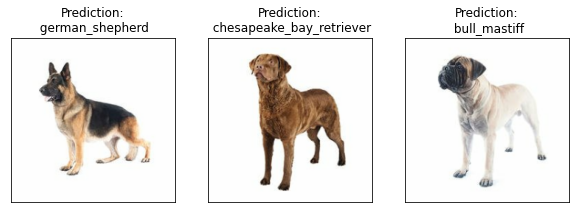

In [116]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction:\n '+custom_pred_labels[i])
    plt.imshow(image)

WOW! It got all the custom images I uploaded correct!